In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# Load pretrained VGG16 model
vgg16_model = load_model(r"C:\Users\K M SASTRY\Desktop\PROJECT\vgg16_model.h5")
vgg16_model = tf.keras.Model(inputs=vgg16_model.input, 
                              outputs=vgg16_model.get_layer('flatten').output)
for layer in vgg16_model.layers:
    layer.trainable = False


In [3]:
train_dir = r"K:\PROJECT\ORGANISED DATASET\train"
test_dir = r"K:\PROJECT\ORGANISED DATASET\test"

In [4]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 6185 images belonging to 2 classes.
Found 1724 images belonging to 2 classes.


In [5]:
def extract_features(generator, model):
    features = model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

# Extract features for train and test datasets
train_features, train_labels = extract_features(train_generator, vgg16_model)
test_features, test_labels = extract_features(test_generator, vgg16_model)

54/54 [==============================] - 490s 9s/step


In [6]:
print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

Train features shape: (6185, 25088)
Test features shape: (1724, 25088)


In [7]:
# Apply PCA on features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

In [8]:
# Print the number of features before applying PCA
print(f"Number of features before PCA: {train_features_scaled.shape[1]}")

Number of features before PCA: 25088


In [9]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% of variance
train_features_pca = pca.fit_transform(train_features_scaled)
test_features_pca = pca.transform(test_features_scaled)

In [10]:
# Print the number of features after applying PCA
print(f"Number of features after PCA: {train_features_pca.shape[1]}")

Number of features after PCA: 3354


In [11]:
# Train the SVM classifier with PCA
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(train_features_pca, train_labels)
print("SVM training complete with PCA.")

SVM training complete with PCA.


In [12]:
# Evaluate the SVM classifier on the test dataset
test_predictions = svm_classifier.predict(test_features_pca)

# Calculate and print the test accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy with PCA: {accuracy:.4f}")

Test Accuracy with PCA: 0.8266


In [13]:
# Print detailed classification report
print("Classification Report with PCA:")
print(classification_report(test_labels, test_predictions, target_names=test_generator.class_indices.keys()))

Classification Report with PCA:
              precision    recall  f1-score   support

      BENIGN       0.72      0.73      0.72       542
   MALIGNANT       0.87      0.87      0.87      1182

    accuracy                           0.83      1724
   macro avg       0.80      0.80      0.80      1724
weighted avg       0.83      0.83      0.83      1724



1/1 [==============================] - 0s 339ms/step


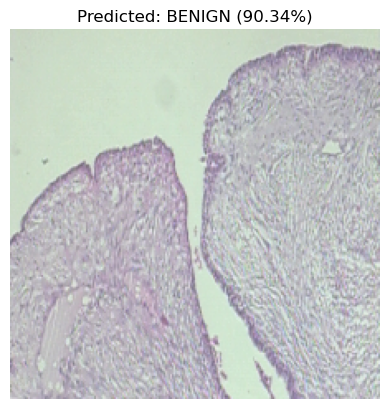

Prediction Probabilities:
BENIGN: 90.34%
MALIGNANT: 9.66%


In [19]:
# Function to make predictions on a single image
def predict_image(image_path, model, svm_classifier, class_indices):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract features using VGG16
    features = model.predict(img_array)

    # Scale the features before applying PCA
    features_scaled = scaler.transform(features)

    # Apply PCA on the extracted features
    features_pca = pca.transform(features_scaled)

    # Predict using the trained SVM classifier
    prediction = svm_classifier.predict(features_pca)
    probabilities = svm_classifier.predict_proba(features_pca)

    # Get class labels
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    predicted_probabilities = probabilities[0]

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({max(predicted_probabilities) * 100:.2f}%)")
    plt.show()

    # Print detailed probabilities
    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), predicted_probabilities):
        print(f"{class_label}: {prob * 100:.2f}%")

# Example usage for predicting a single image
image_path = r"K:\PROJECT\ORGANISED DATASET\test\BENIGN\phyllodes_tumor\SOB_B_PT_14-21998AB\40X\SOB_B_PT-14-21998AB-40-007.png" 
predict_image(image_path, vgg16_model, svm_classifier, train_generator.class_indices)

1/1 [==============================] - 0s 331ms/step


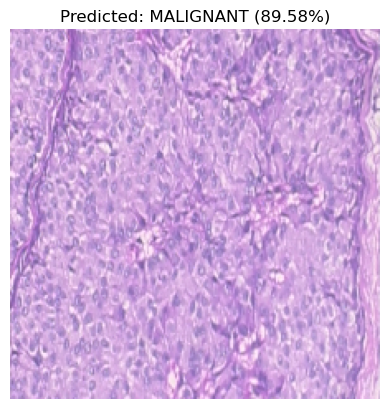

Prediction Probabilities:
BENIGN: 10.42%
MALIGNANT: 89.58%


In [20]:
# Function to make predictions on a single image
def predict_image(image_path, model, svm_classifier, class_indices):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Extract features using VGG16
    features = model.predict(img_array)

    # Scale the features before applying PCA
    features_scaled = scaler.transform(features)

    # Apply PCA on the extracted features
    features_pca = pca.transform(features_scaled)

    # Predict using the trained SVM classifier
    prediction = svm_classifier.predict(features_pca)
    probabilities = svm_classifier.predict_proba(features_pca)

    # Get class labels
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = class_labels[prediction[0]]
    predicted_probabilities = probabilities[0]

    # Display the image
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class} ({max(predicted_probabilities) * 100:.2f}%)")
    plt.show()

    # Print detailed probabilities
    print("Prediction Probabilities:")
    for class_label, prob in zip(class_labels.values(), predicted_probabilities):
        print(f"{class_label}: {prob * 100:.2f}%")

# Example usage for predicting a single image
image_path = r"K:\PROJECT\ORGANISED DATASET\test\MALIGNANT\mucinous_carcinoma\SOB_M_MC_14-13413\100X\SOB_M_MC-14-13413-100-014.png"
predict_image(image_path, vgg16_model, svm_classifier, train_generator.class_indices)

In [21]:
import joblib
from keras.models import load_model
from sklearn.decomposition import PCA
from sklearn.svm import SVC


# 1. Save the VGG16 model
vgg16_model.save(r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\vgg16_with_svm_pca.h5')
print("VGG16 model saved.")

# 2. Save the PCA model
joblib.dump(pca, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\pca_model.pkl')
print("PCA model saved.")

# 3. Save the SVM classifier model
joblib.dump(svm_classifier, r'C:\Users\K M SASTRY\Desktop\CAPSTONE PROJECT\svm_classifier_model.pkl')
print("SVM classifier model saved.")


C:\Users\K M SASTRY\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


VGG16 model saved.
PCA model saved.
SVM classifier model saved.
